# Project Playground - Module 5 - Ver.1

<br> David Mauger
<br> Data Science - Full Time Immersive
<br> Date: Dec 2, 2019
<br> Howard Smith & Amanda Yandow
<br> https://github.com/Maugy

# Project: Predicting iOS Game Success

## Overview
1. [Objective & Background](#001)
2. [Obtaining Data & Defining Functions](#002)
3. [Scrubbing Data](#003)
4. [Exploring Data](#004)
5. [Modeling Data](#005)
6. [Interpreting Data](#006)


<a id="001"></a>

## 1) Objective & Background
***


**1.1 Objective:**
> Create Machine Learning model(s) to predict likelihood of an iOS app to achieve at least a 4 Star Rating in the App Store. 

**1.2 Data Provided:** 
><br>1. Data scraped from iOS Games in the Strategy Genre in August 2019 - using iTunes API and BeautifulSoup.
<br> 2. Over 17,000 Strategy games - including successful releases like Clash of Clans and Pokemon GO. 
<br> 3. 18 distinct features including: subgenres, rating count/details, descriptive features, pricing, additional services. 
<br>

**1.3 Methodology**
> OSEMN Process
>    - Obtain Data
>    - Scrub Data
>    - Explore Data
>    - Model Data
>    - Interpret Data

<a id="002"></a>

## 2) Obtaining Data & Defining Functions
***

#### 2.1 Import packages and models:

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime

import itertools
from itertools import combinations, cycle

import statsmodels as sm
import statsmodels.api as sm
from statsmodels.formula.api import ols

import xgboost as xgb

from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LassoLarsCV, LassoLarsIC, lasso_path, enet_path
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.feature_selection import VarianceThreshold, f_regression, mutual_info_regression, SelectKBest, RFE, RFECV
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier

from scipy import stats
import scipy.stats as st
from scipy.stats import shapiro

from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.
/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

#### 2.2 Import visualization libraries:

In [2]:
from pivottablejs import pivot_ui

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns 
sns.set_style('darkgrid')

#### 2.3 Import re-usable functions:

In [3]:
def prediction_function(model,train_x,test_x, train_y,test_y, estimate=None):
    
    cols = [i for i in df.columns if i not in df['Average_User_Rating']]
    
    model.fit(train_x,train_y)
    predictions = model.predict(test_x)
    probabilities = model.predict_proba(test_x)
    
    predict_train = model.predict(train_x)
    prob_train = model.predict_proba(train_x)
    
    
    if estimate == 'dec_tree':
        coefficients = pd.DataFrame(model.feature_importances_)
    elif estimate == 'rfe':
        coefficients = pd.DataFrame(model.estimator_.coef_.ravel())
    else:
        coefficients = pd.DataFrame(model.coef_.ravel())
    
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (model)
    print ("\n Score Report : \n",classification_report(test_y,predictions))
    print ("Accuracy Score : ",accuracy_score(test_y,predictions))
    print ('Training Root Mean Square Error',np.sqrt(metrics.mean_squared_error(train_y,predict_train)))
    print ('Testing Root Mean Square Error',np.sqrt(metrics.mean_squared_error(test_y,predictions)))
    
    
    c_matrix = confusion_matrix(test_y,predictions)
    cnf_matrix = pd.DataFrame(c_matrix)
    
    model_roc_auc = roc_auc_score(test_y,predictions) 
    print ("AUC : ",model_roc_auc,"\n")
    test_fpr,test_tpr,test_thresholds = roc_curve(test_y, probabilities[:,1])
    train_fpr,train_tpr,train_thresholds = roc_curve(train_y, prob_train[:,1])
    
    trace1 = go.Heatmap(z = cnf_matrix ,
                        x = ["1 to 4 Stars","4+ Stars"],
                        y = ["1 to 4 Stars","4+ Stars"],
                        showscale  = False,colorscale = "Viridis",
                        name = "matrix")
    
    trace2 = go.Scatter(x = test_fpr,y = test_tpr,
                        name = "ROC Test",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    trace4 = go.Scatter(x = train_fpr,y=train_tpr,
                        name= "ROC Train",
                        line = dict(color = ('rgb(255, 128, 0)'),width = 2))
    
    trace5 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('ROC Curve','Confusion Matrix','Feature Ranking'))
    
    fig.append_trace(trace1,1,2)
    fig.append_trace(trace2,1,1)
    fig.append_trace(trace3,1,1)
    fig.append_trace(trace4,1,1)
    fig.append_trace(trace5,2,1)
    
    fig['layout'].update(showlegend=False, title="Model Performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    
    py.iplot(fig)

In [4]:
def model_score(model,train_x,test_x,train_y,test_y,name):
    model.fit(train_x,train_y)
    predictions  = model.predict(test_x)
    accuracy     = accuracy_score(test_y,predictions)
    recallscore  = recall_score(test_y,predictions)
    precision    = precision_score(test_y,predictions)
    roc_auc      = roc_auc_score(test_y,predictions)
    f1score      = f1_score(test_y,predictions) 
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc]})
    return df


In [5]:
def model_compare(metric,color) :
    chart = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color))
    return chart

In [6]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))

#### 2.4 Import data:

In [7]:
df = pd.read_csv('appstore_games.csv')
df_original = df.copy()
df.head()

URL         ID  \
0   https://apps.apple.com/us/app/sudoku/id284921427  284921427   
1  https://apps.apple.com/us/app/reversi/id284926400  284926400   
2  https://apps.apple.com/us/app/morocco/id284946595  284946595   
3  https://apps.apple.com/us/app/sudoku-free/id28...  285755462   
4  https://apps.apple.com/us/app/senet-deluxe/id2...  285831220   

            Name Subtitle                                           Icon URL  \
0         Sudoku      NaN  https://is2-ssl.mzstatic.com/image/thumb/Purpl...   
1        Reversi      NaN  https://is4-ssl.mzstatic.com/image/thumb/Purpl...   
2        Morocco      NaN  https://is5-ssl.mzstatic.com/image/thumb/Purpl...   
3  Sudoku (Free)      NaN  https://is3-ssl.mzstatic.com/image/thumb/Purpl...   
4   Senet Deluxe      NaN  https://is1-ssl.mzstatic.com/image/thumb/Purpl...   

   Average User Rating  User Rating Count  Price In-app Purchases  \
0                  4.0             3553.0   2.99              NaN   
1                  3.5              284.0   1.99              NaN   
2                  3.0             8376.0   0.00              NaN   
3                  3.5           190394.0   0.00              NaN   
4                  3.5               28.0   2.99              NaN   

                                         Description  \
0  Join over 21,000,000 of our fans and download ...   
1  The classic game of Reversi, also known as Oth...   
2  Play the classic strategy game Othello (also k...   
3  Top 100 free app for over a year.\nRated "Best...   
4  "Senet Deluxe - The Ancient Game of Life and A...   

                  Developer Age Rating  \
0  Mighty Mighty Good Games         4+   
1          Kiss The Machine         4+   
2               Bayou Games         4+   
3  Mighty Mighty Good Games         4+   
4           RoGame Software         4+   

                                           Languages        Size  \
0  DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...  15853568.0   
1                                                 EN  12328960.0   
2                                                 EN    674816.0   
3  DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...  21552128.0   
4  DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...  34689024.0   

  Primary Genre                             Genres Original Release Date  \
0         Games            Games, Strategy, Puzzle            11/07/2008   
1         Games             Games, Strategy, Board            11/07/2008   
2         Games             Games, Board, Strategy            11/07/2008   
3         Games            Games, Strategy, Puzzle            23/07/2008   
4         Games  Games, Strategy, Board, Education            18/07/2008   

  Current Version Release Date  
0                   30/05/2017  
1                   17/05/2018  
2                    5/09/2017  
3                   30/05/2017  
4                   22/07/2018

<a id="003"></a>

## 3)  Scrubbing Data
***


**3.1** - [Data Observations](#3.1) 
<br>**3.2** - [Modify Datatypes & Replace Values](#3.2) 
<br> 

<a id="3.1"></a>

### 3.1 - Data Observations

In [8]:
pandas_profiling.ProfileReport(df)

In [9]:
print('\n *Data Shape* \n', df.shape)
print('\n *Data Info* \n')
df.info()
print('\n *Data Description* \n')
df.describe()


 *Data Shape* 
 (17007, 18)

 *Data Info* 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
URL                             17007 non-null object
ID                              17007 non-null int64
Name                            17007 non-null object
Subtitle                        5261 non-null object
Icon_URL                        17007 non-null object
Average_User_Rating             7561 non-null float64
User_Rating_Count               7561 non-null float64
Price                           16983 non-null float64
In-app_Purchases                7683 non-null object
Description                     17007 non-null object
Developer                       17007 non-null object
Age_Rating                      17007 non-null object
Languages                       16947 non-null object
Size                            17006 non-null float64
Primary_Genre                   17007 non-null object
Genres                          17007

ID  Average_User_Rating  User_Rating_Count         Price  \
count  1.700700e+04          7561.000000       7.561000e+03  16983.000000   
mean   1.059614e+09             4.060905       3.306531e+03      0.813419   
std    2.999676e+08             0.751428       4.232256e+04      7.835732   
min    2.849214e+08             1.000000       5.000000e+00      0.000000   
25%    8.996543e+08             3.500000       1.200000e+01      0.000000   
50%    1.112286e+09             4.500000       4.600000e+01      0.000000   
75%    1.286983e+09             4.500000       3.090000e+02      0.000000   
max    1.475077e+09             5.000000       3.032734e+06    179.990000   

               Size  
count  1.700600e+04  
mean   1.157064e+08  
std    2.036477e+08  
min    5.132800e+04  
25%    2.295014e+07  
50%    5.676895e+07  
75%    1.330271e+08  
max    4.005591e+09

In [10]:
# identify null values
df.isna().sum()

URL                                 0
ID                                  0
Name                                0
Subtitle                        11746
Icon_URL                            0
Average_User_Rating              9446
User_Rating_Count                9446
Price                              24
In-app_Purchases                 9324
Description                         0
Developer                           0
Age_Rating                          0
Languages                          60
Size                                1
Primary_Genre                       0
Genres                              0
Original_Release_Date               0
Current_Version_Release_Date        0
dtype: int64

In [11]:
# examine target variable
df['Average_User_Rating'].value_counts()

4.5    2861
4.0    1722
5.0     990
3.5     925
3.0     514
2.5     317
2.0     158
1.5      60
1.0      14
Name: Average_User_Rating, dtype: int64

<a id="3.2"></a>

### 3.2 - Modify Datatypes & Replace Values

In [12]:
# drop columns that are beyond the interest/scope/impact
df = df.drop(['Subtitle','URL','ID','Icon_URL'], axis=1)
df.head()

Name  Average_User_Rating  User_Rating_Count  Price  \
0         Sudoku                  4.0             3553.0   2.99   
1        Reversi                  3.5              284.0   1.99   
2        Morocco                  3.0             8376.0   0.00   
3  Sudoku (Free)                  3.5           190394.0   0.00   
4   Senet Deluxe                  3.5               28.0   2.99   

  In-app_Purchases                                        Description  \
0              NaN  Join over 21,000,000 of our fans and download ...   
1              NaN  The classic game of Reversi, also known as Oth...   
2              NaN  Play the classic strategy game Othello (also k...   
3              NaN  Top 100 free app for over a year.\nRated "Best...   
4              NaN  "Senet Deluxe - The Ancient Game of Life and A...   

                  Developer Age_Rating  \
0  Mighty Mighty Good Games         4+   
1          Kiss The Machine         4+   
2               Bayou Games         4+   
3  Mighty Mighty Good Games         4+   
4           RoGame Software         4+   

                                           Languages        Size  \
0  DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...  15853568.0   
1                                                 EN  12328960.0   
2                                                 EN    674816.0   
3  DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...  21552128.0   
4  DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...  34689024.0   

  Primary_Genre                             Genres Original_Release_Date  \
0         Games            Games, Strategy, Puzzle            11/07/2008   
1         Games             Games, Strategy, Board            11/07/2008   
2         Games             Games, Board, Strategy            11/07/2008   
3         Games            Games, Strategy, Puzzle            23/07/2008   
4         Games  Games, Strategy, Board, Education            18/07/2008   

  Current_Version_Release_Date  
0                   30/05/2017  
1                   17/05/2018  
2                    5/09/2017  
3                   30/05/2017  
4                   22/07/2018

In [13]:
df.Genres.value_counts()

Games, Strategy, Puzzle                     778
Games, Puzzle, Strategy                     694
Games, Strategy                             588
Games, Strategy, Action                     483
Games, Simulation, Strategy                 465
                                           ... 
Games, Strategy, Utilities, Word              1
Games, Productivity, Board, Strategy          1
Games, Strategy, Family, Travel               1
Games, Sports, Business, Strategy             1
Games, Strategy, Adventure, Food & Drink      1
Name: Genres, Length: 1004, dtype: int64

In [14]:
# split genre lists that include multiple subgenres
genres = df['Genres'].str.split(', ')

In [15]:
# Binarize individual genres
mlb = MultiLabelBinarizer()
expanded_label_data = mlb.fit_transform(df['Genres'].str.split(', '))
label_classes = mlb.classes_
print(label_classes)

expanded_labels = pd.DataFrame(expanded_label_data, columns=label_classes)
print('Sum: ', expanded_labels.sum())

['Action' 'Adventure' 'Animals & Nature' 'Art' 'Board' 'Books' 'Business'
 'Card' 'Casino' 'Casual' 'Comics & Cartoons' 'Education'
 'Emoji & Expressions' 'Entertainment' 'Family' 'Finance' 'Food & Drink'
 'Games' 'Gaming' 'Health & Fitness' 'Kids & Family' 'Lifestyle'
 'Magazines & Newspapers' 'Medical' 'Music' 'Navigation' 'News' 'People'
 'Photo & Video' 'Places & Objects' 'Productivity' 'Puzzle' 'Racing'
 'Reference' 'Role Playing' 'Shopping' 'Simulation' 'Social Networking'
 'Sports' 'Sports & Activities' 'Stickers' 'Strategy' 'Travel' 'Trivia'
 'Utilities' 'Weather' 'Word']
Sum:  Action                     2012
Adventure                   836
Animals & Nature              4
Art                           2
Board                      1722
Books                        38
Business                     45
Card                        674
Casino                       75
Casual                     1697
Comics & Cartoons             2
Education                   951
Emoji & Expressions    

In [16]:
# drop original columns
expanded_labels = expanded_labels.drop(['Games', 'Strategy'], axis=1)
expanded_labels.sum()

Action                    2012
Adventure                  836
Animals & Nature             4
Art                          2
Board                     1722
Books                       38
Business                    45
Card                       674
Casino                      75
Casual                    1697
Comics & Cartoons            2
Education                  951
Emoji & Expressions         15
Entertainment             7991
Family                     773
Finance                     51
Food & Drink                57
Gaming                      25
Health & Fitness            34
Kids & Family                3
Lifestyle                  220
Magazines & Newspapers       1
Medical                      7
Music                      103
Navigation                  15
News                        20
People                       3
Photo & Video               25
Places & Objects             4
Productivity                62
Puzzle                    3960
Racing                     129
Referenc

In [17]:
# group values under 500 into a new column
other_genres = expanded_labels.loc[:,(expanded_labels.sum() <= 500)]

In [18]:
columns = {'Animals & Nature': 'Other', 'Art': 'Other', 'Books': 'Other', 'Business': 'Other', 'Casino': 'Other',
       'Comics & Cartoons': 'Other', 'Emoji & Expressions': 'Other', 'Finance': 'Other', 'Food & Drink': 'Other',
       'Gaming': 'Other', 'Health & Fitness': 'Other', 'Kids & Family': 'Other', 'Lifestyle': 'Other',
       'Magazines & Newspapers': 'Other', 'Medical': 'Other', 'Music': 'Other', 'Navigation': 'Other', 'News': 'Other',
       'People': 'Other', 'Photo & Video': 'Other', 'Places & Objects': 'Other', 'Productivity': 'Other', 'Racing': 'Other',
       'Reference': 'Other', 'Shopping': 'Other', 'Social Networking': 'Other', 'Sports & Activities': 'Other',
       'Stickers': 'Other', 'Travel': 'Other', 'Trivia': 'Other', 'Utilities': 'Other', 'Weather': 'Other', 'Word': 'Other'}

In [19]:
df_other = other_genres.groupby(columns, axis=1).sum()
df_other.reset_index(drop=True)

Other
0          0
1          0
2          0
3          0
4          0
...      ...
17002      0
17003      0
17004      0
17005      0
17006      0

[17007 rows x 1 columns]

In [20]:
expanded_labels['Other'] = df_other['Other']

In [21]:
# drop columns that are now accounted for in 'other' column
expanded_labels = expanded_labels.drop(['Animals & Nature', 'Art', 'Books', 'Business', 'Casino',
       'Comics & Cartoons', 'Emoji & Expressions', 'Finance', 'Food & Drink',
       'Gaming', 'Health & Fitness', 'Kids & Family', 'Lifestyle',
       'Magazines & Newspapers', 'Medical', 'Music', 'Navigation', 'News',
       'People', 'Photo & Video', 'Places & Objects', 'Productivity', 'Racing',
       'Reference', 'Shopping', 'Social Networking', 'Sports & Activities',
       'Stickers', 'Travel', 'Trivia', 'Utilities', 'Weather', 'Word'], axis=1)


In [22]:
# drop columns that are now accounted for in new columns
df = df.drop(['Genres', 'Primary_Genre'], axis=1)

In [23]:
# concat binarized genre labels back into main dataframe
df = pd.concat([df.reset_index(drop=True), expanded_labels.reset_index(drop=True)], axis=1)
print('Shape: ', df.shape)

Shape:  (17007, 25)


In [24]:
# fill null values with 0.0 for in-app purchases
df['In-app_Purchases'] = df['In-app_Purchases'].fillna(value='0.0')

In [25]:
df['In-app_Purchases'] = df['In-app_Purchases'].str.split(', ')

In [26]:
# binarize in-app purchase categories
mlb_inapp = MultiLabelBinarizer()
expandedLabelData = mlb_inapp.fit_transform(df['In-app_Purchases'])
labelClasses = mlb_inapp.classes_
print(labelClasses)

# Create a pandas.DataFrame from our output
expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)
expandedLabels.head()

['0' '0.0' '0.49' '0.99' '1.49' '1.99' '10.99' '109.99' '11.99' '119.99'
 '12.99' '129.99' '13.99' '139.99' '14.49' '14.99' '15.99' '16.49' '16.99'
 '169.99' '17.49' '17.99' '18.99' '19.49' '19.99' '199.99' '2.49' '2.99'
 '20.99' '21.99' '22.99' '23.49' '23.99' '24.99' '25.99' '26.99' '27.99'
 '28.99' '29.99' '299.99' '3.49' '3.99' '30.99' '31.99' '32.99' '33.99'
 '34.99' '35.99' '36.99' '37.99' '38.99' '39.99' '4.49' '4.99' '40.99'
 '41.99' '42.99' '43.99' '44.99' '45.99' '46.99' '47.99' '48.99' '49.99'
 '5.49' '5.99' '54.99' '59.99' '6.99' '64.99' '69.99' '7.49' '7.99'
 '74.99' '79.99' '8.49' '8.99' '84.99' '89.99' '9.49' '9.99' '94.99'
 '99.99']


0  0.0  0.49  0.99  1.49  1.99  10.99  109.99  11.99  119.99  ...  74.99  \
0  0    1     0     0     0     0      0       0      0       0  ...      0   
1  0    1     0     0     0     0      0       0      0       0  ...      0   
2  0    1     0     0     0     0      0       0      0       0  ...      0   
3  0    1     0     0     0     0      0       0      0       0  ...      0   
4  0    1     0     0     0     0      0       0      0       0  ...      0   

   79.99  8.49  8.99  84.99  89.99  9.49  9.99  94.99  99.99  
0      0     0     0      0      0     0     0      0      0  
1      0     0     0      0      0     0     0      0      0  
2      0     0     0      0      0     0     0      0      0  
3      0     0     0      0      0     0     0      0      0  
4      0     0     0      0      0     0     0      0      0  

[5 rows x 83 columns]

<a id="004"></a>

## 4) Data Exploration & Plotting
***

<br>4.1 [Visual Inspection](#4.1)
<br>4.2 [Feature Engineering](#4.2)
<br>4.3 [Finalize Dataset](#4.3)


<a id="4.1"></a>

### 4.1 Visual Inspection

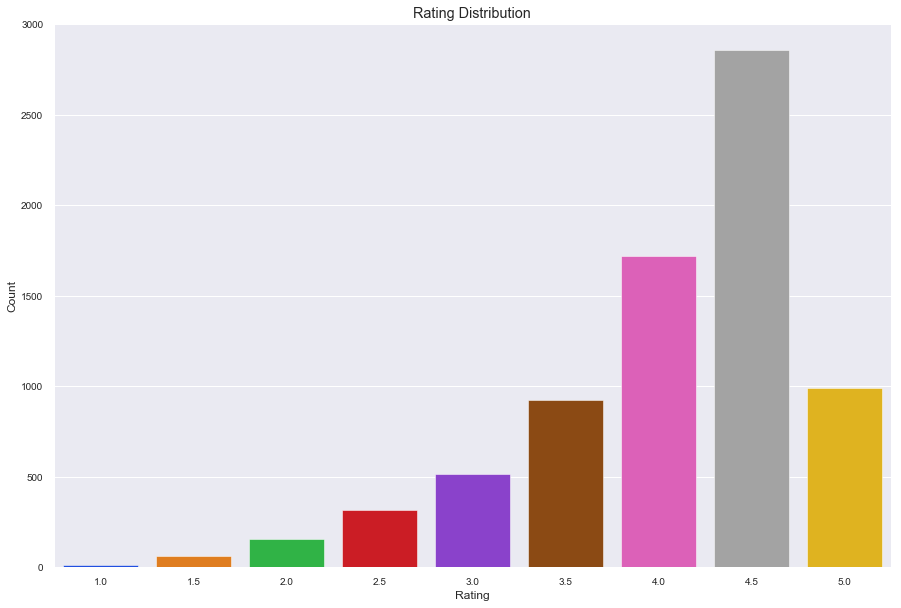

In [27]:
# examine target category visually
user_rating = df['Average_User_Rating'].value_counts()
plt.figure(figsize=(15,10))
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
sns.barplot(user_rating.index, user_rating.values, palette='bright');

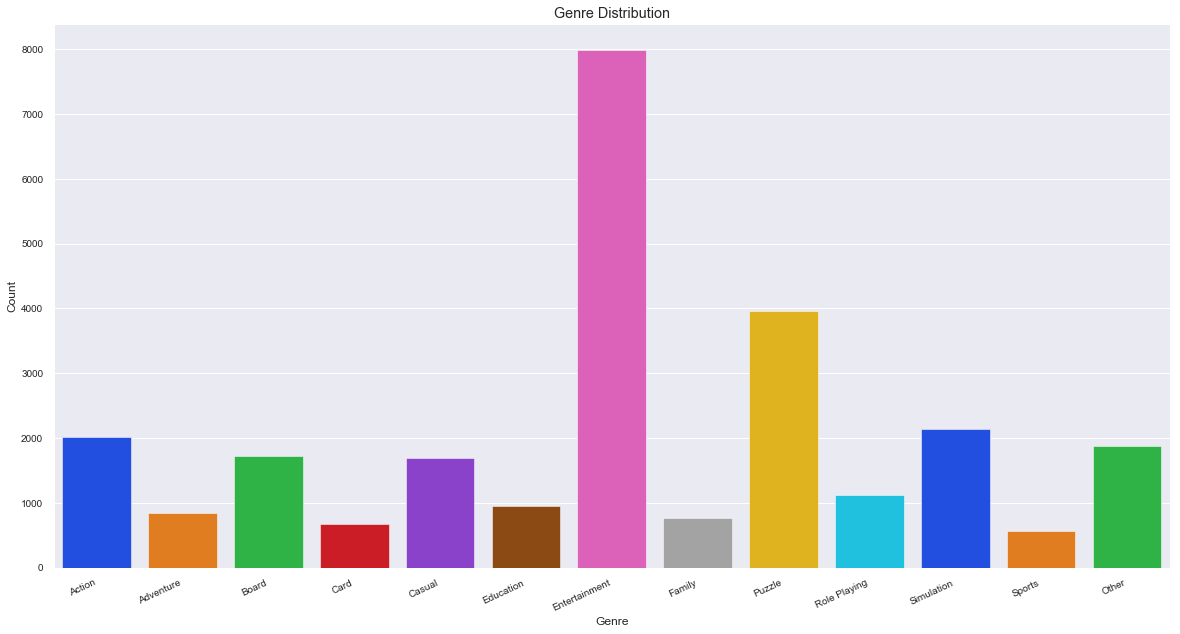

In [28]:
# examine genre distribution
columns = list(expanded_labels.columns.values)
plt.figure(figsize=(20,10))
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Genre Distribution")
genre_plot = sns.barplot(columns, expanded_labels.sum().values, palette='bright')
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation='25', ha='right');

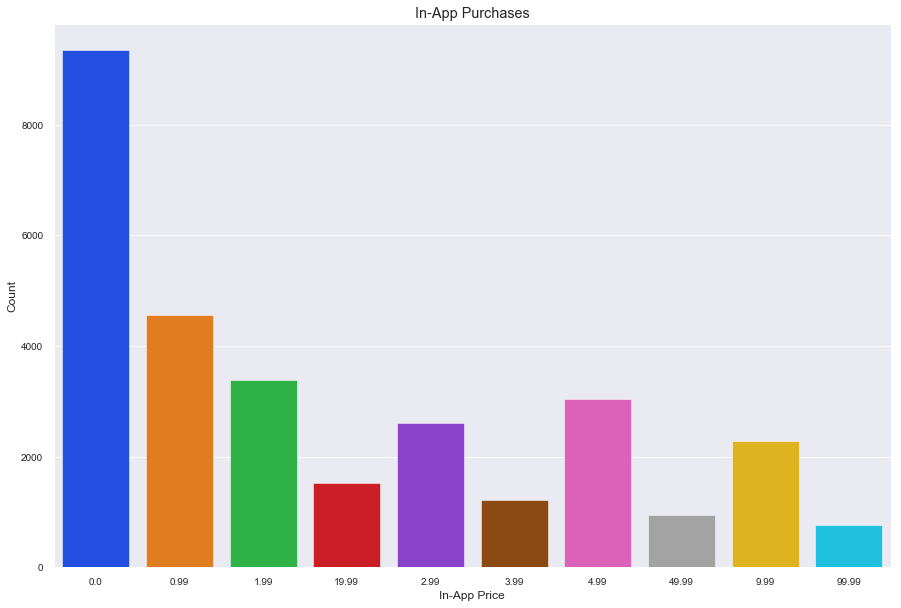

In [29]:
# examine highest count for in-app purchases
max_10_prices = expandedLabels.sum().sort_values(ascending=False)[:10]
plt.figure(figsize=(15,10))
plt.xlabel("In-App Price")
plt.ylabel("Count")
plt.title("In-App Purchases")
sns.barplot(max_10_prices.index, max_10_prices.values, palette='bright');

<a id="4.2"></a>

### 4.2 Feature Engineering

In [30]:
# examine length of descriptions and impact on success
desc = df['Description']
desc_lengths = [len(de) for de in desc]
df['desc_lengths'] = desc_lengths

In [31]:
# time series analysis on releast date to most recent version - aka how long the app has been released
date_format = "%d/%m/%Y"
(datetime.strptime(df['Current_Version_Release_Date'][1], date_format) -
 datetime.strptime(df['Original_Release_Date'][1], date_format)).days

3597

In [32]:
date_extracted = datetime.strptime('3/7/2019', date_format)
date_extracted

datetime.datetime(2019, 7, 3, 0, 0)

In [33]:
time_diff = []

for i in range(len(df)):
    current = df['Current_Version_Release_Date'][i]
    original = df['Original_Release_Date'][i]
    difference = datetime.strptime(
        current, date_format) - datetime.strptime(original, date_format)
    time_diff.append(difference.days)

df['Difference_in_Days'] = np.array(time_diff)
df['Original_Release_Date'] = np.array(
    [(date_extracted - datetime.strptime(date, date_format)).days for date in df['Original_Release_Date']])
df['Current_Version_Release_Date'] = np.array([(date_extracted - datetime.strptime(
    date, date_format)).days for date in df['Current_Version_Release_Date']])

In [34]:
df['Age_Rating'] = df['Age_Rating'].map({'4+': 4, '9+': 9, '12+': 12, '17+': 17}).astype(float)

In [35]:
%%HTML
<div class='tableauPlaceholder' id='viz1575149436113' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ap&#47;App_Games_Tableau&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='App_Games_Tableau&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ap&#47;App_Games_Tableau&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1575149436113');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [36]:
%%HTML
<div class='tableauPlaceholder' id='viz1575149755095' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ap&#47;App_Games_Tableau&#47;DescriptionLength&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='App_Games_Tableau&#47;DescriptionLength' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ap&#47;App_Games_Tableau&#47;DescriptionLength&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1575149755095');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

<a id="4.3"></a>

### 4.3 Finalize Dataset

In [37]:
df['Average_User_Rating'].fillna(0, inplace=True)
df['Average_User_Rating'].isna().sum()

0

In [38]:
df['User_Rating_Count'].fillna(0, inplace=True)
df['User_Rating_Count'].isna().sum()

0

In [39]:
df.Price.fillna(0.00, inplace=True)
df.Size.fillna(0.00, inplace=True)

In [40]:
df.dropna(inplace=True, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16947 entries, 0 to 17006
Data columns (total 27 columns):
Name                            16947 non-null object
Average_User_Rating             16947 non-null float64
User_Rating_Count               16947 non-null float64
Price                           16947 non-null float64
In-app_Purchases                16947 non-null object
Description                     16947 non-null object
Developer                       16947 non-null object
Age_Rating                      16947 non-null float64
Languages                       16947 non-null object
Size                            16947 non-null float64
Original_Release_Date           16947 non-null int64
Current_Version_Release_Date    16947 non-null int64
Action                          16947 non-null int64
Adventure                       16947 non-null int64
Board                           16947 non-null int64
Card                            16947 non-null int64
Casual                      

In [41]:
df.drop_duplicates(subset='Name', keep='first', inplace=True)

In [42]:
df_features = df.drop(['Name','Developer', 'Average_User_Rating', 'In-app_Purchases', 'Languages', 'Description', 'Original_Release_Date', 'Current_Version_Release_Date'], axis=1)
df_target = pd.DataFrame(df['Average_User_Rating'])

In [43]:
df_features = df_features.astype(float)

In [44]:
# categorize target category into two bins: successful and not successful
cat = [0, 1]
bins = [0., 3., 6.]
rating_bins = pd.cut(df['Average_User_Rating'], bins, labels=cat, right=False)

print('\n Rating Bins:')
print(rating_bins.unique())
print(rating_bins.value_counts())
rating_bins.isna().sum()


 Rating Bins:
[1, 0]
Categories (2, int64): [0 < 1]
0    9860
1    6927
Name: Average_User_Rating, dtype: int64


0

In [45]:
rating_bins = pd.DataFrame(rating_bins)
rating_bins = pd.DataFrame(rating_bins['Average_User_Rating'].astype(float))

In [46]:
# create clean dataset for modeling.
df = pd.concat([df_features.reset_index(drop=True), rating_bins.reset_index(drop=True)], axis=1)
print(df.shape)
df.head()

(16787, 20)


User_Rating_Count  Price  Age_Rating        Size  Action  Adventure  Board  \
0             3553.0   2.99         4.0  15853568.0     0.0        0.0    0.0   
1              284.0   1.99         4.0  12328960.0     0.0        0.0    1.0   
2             8376.0   0.00         4.0    674816.0     0.0        0.0    1.0   
3           190394.0   0.00         4.0  21552128.0     0.0        0.0    0.0   
4               28.0   2.99         4.0  34689024.0     0.0        0.0    1.0   

   Card  Casual  Education  Entertainment  Family  Puzzle  Role Playing  \
0   0.0     0.0        0.0            0.0     0.0     1.0           0.0   
1   0.0     0.0        0.0            0.0     0.0     0.0           0.0   
2   0.0     0.0        0.0            0.0     0.0     0.0           0.0   
3   0.0     0.0        0.0            0.0     0.0     1.0           0.0   
4   0.0     0.0        1.0            0.0     0.0     0.0           0.0   

   Simulation  Sports  Other  desc_lengths  Difference_in_Days  \
0         0.0     0.0    0.0        1617.0              3245.0   
1         0.0     0.0    0.0        1222.0              3597.0   
2         0.0     0.0    0.0         582.0              3343.0   
3         0.0     0.0    0.0        1675.0              3233.0   
4         0.0     0.0    0.0        2076.0              3656.0   

   Average_User_Rating  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0

<a id="005"></a>

<a id="005"></a>

## 5) Modeling Data
***

[Intermediate Models:](#Stats.Models)
<br>5.1 [Baseline Model](#5.1)
<br>5.2 [SMOTE](#5.2)
<br>5.3 [Lasso](#5.3)
<br>5.4 [Ridge](#5.4)
<br>5.5 [RFE](#5.5)
<br>
<br>[Advanced Models:](#ML.Models)
<br>5.6 [PCA](#5.6)
<br>5.7 [Decision Tree](#5.7)
<br>5.8 [Random Forest](#5.8)
<br>5.9 [XGBoost](#5.9)
<br>5.10 [AdaBoost Classifier](#5.10)
<br>5.11 [GBT Classifier](#5.11)
<br>5.12 [K-Nearest Neighbors](#5.12)
<br>5.13 [Ensemble / Meta-Classifier](5.13)

> **Evaluation Metrics:**
- **Precision**: What proportion of positive identifications were actually correct?
- **Recall**: What proportion of actual positives were identified correctly?
- **𝐹1 𝑆𝑐𝑜𝑟𝑒**: Combines precision and recall into a single metric. A simple way to compare two classifiers. The harmonic mean of precision and recall (the regular mean treats all values equally, the harmonic mean gives much more weight to low values.) A classifier will only get a high F1 score if both recall and precision are high.
- **ROC Curve**: The best performing models will have an ROC curve that hugs the upper left corner of the graph.
- **AUC**: A perfect classifier will have a AUC equal to 1. Purely random classifier will have a AUC equal to 0.5.

<a id="Stats.Models"></a>

## Intermediate Models

<a id="5.1"></a>

### 5.1 Baseline Model

### Train/Test Split

In [47]:
X = df.drop(['Average_User_Rating'], axis=1)
y = df['Average_User_Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

logreg = LogisticRegression() 
baseline_log = logreg.fit(X_train, y_train)
print(baseline_log) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [48]:
prediction_function(baseline_log, X_train, X_test, y_train, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1993
         1.0       0.41      1.00      0.58      1365

    accuracy                           0.41      3358
   macro avg       0.20      0.50      0.29      3358
weighted avg       0.17      0.41      0.23      3358

Accuracy Score :  0.4064919594997022
Training Root Mean Square Error 0.7653899196447209
Testing Root Mean Square Error 0.7703947303170614
AUC :  0.5 



/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Scaling

In [49]:
scaler = MinMaxScaler().fit(X_train)
X_trans = scaler.transform(X_train)
X_train_transformed = pd.DataFrame(X_trans, columns=X_train.columns, index=X_train.index)

In [50]:
scaler = MinMaxScaler().fit(X_test)
X_testy = scaler.transform(X_test)
X_test_transformed = pd.DataFrame(X_testy, columns=X_test.columns, index=X_test.index)

<a id="5.2"></a>

### 5.2 SMOTE


In [51]:
smote = SMOTE()
X_smote_train, y_smote_train = smote.fit_sample(X_train_transformed, y_train) 
X_smote_test, y_smote_test = smote.fit_sample(X_test_transformed, y_test) 
smote_log = LogisticRegression(fit_intercept = False, C = 1e12,solver ='lbfgs', random_state=123)
smote_logit = smote_log.fit(X_smote_train, y_smote_train)   

/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



In [52]:
prediction_function(smote_logit, X_smote_train, X_smote_test, y_smote_train, y_smote_test)

/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

         0.0       0.69      0.72      0.70      1993
         1.0       0.71      0.68      0.69      1993

    accuracy                           0.70      3986
   macro avg       0.70      0.70      0.70      3986
weighted avg       0.70      0.70      0.70      3986

Accuracy Score :  0.6994480682388359
Training Root Mean Square Error 0.5566885330159111
Testing Root Mean Square Error 0.5482261684388698
AUC :  0.6994480682388359 



<a id="5.3"></a>

### 5.3 Lasso Model

In [53]:
log_lasso = LogisticRegression(penalty='l1', random_state=123)
logit_lasso = log_lasso.fit(X_train_transformed,y_train)
prediction_function(logit_lasso,X_train_transformed,X_test_transformed,y_train,y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

         0.0       0.73      0.85      0.79      1993
         1.0       0.71      0.54      0.62      1365

    accuracy                           0.72      3358
   macro avg       0.72      0.70      0.70      3358
weighted avg       0.72      0.72      0.72      3358

Accuracy Score :  0.7248362120309708
Training Root Mean Square Error 0.5320889247801595
Testing Root Mean Square Error 0.5245605665402511
AUC :  0.6960497271586081 



<a id="5.4"></a>

### 5.4 Ridge Model (Balanced)

In [54]:
ridge_logreg = LogisticRegression(class_weight='balanced', random_state=123)
ridge_logit = ridge_logreg.fit(X_train_transformed,y_train)

prediction_function(ridge_logit,X_train_transformed,X_test_transformed,y_train,y_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

         0.0       0.76      0.76      0.76      1993
         1.0       0.65      0.65      0.65      1365

    accuracy                           0.71      3358
   macro avg       0.70      0.70      0.70      3358
weighted avg       0.71      0.71      0.71      3358

Accuracy Score :  0.7126265634306135
Training Root Mean Square Error 0.5364792293386602
Testing Root Mean Square Error 0.5360722307389056
AUC :  0.7028462255256033 



<a id="5.5"></a>

### 5.5 RFE

In [55]:
logit = LogisticRegression()
rfe = RFE(logit, 10)
X_rfe_train = rfe.fit_transform(X_train_transformed,y_train)
X_rfe_test = rfe.transform(X_test_transformed)
rfe = rfe.fit(X_rfe_train,y_train.values.ravel())
prediction_function(rfe,X_rfe_train,X_rfe_test,y_train,y_test, 'rfe')

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

 Score Report : 
               precision    recall  f1-score   support

         0.0       0.73      0.85      0.79      1993
         1.0       0.72      0.53      0.61      1365

    accuracy                           0.72      3358
   macro avg       0.72      0.69      0.70      3358
weighted avg       0.72      0.72      0.71      3358

Accuracy Score :  0.7239428231089935
Training Root Mean Square Error 0.538142305079978
Testing Root Mean Square Error 0.5254114358205448
AUC :  0.6937966031292674 



<a id="ML.Models"></a>

## Advanced Models

<a id="5.6"></a>

### 5.6 Principal Component Analysis

In [56]:
pca_X2 = df.drop(['Average_User_Rating'], axis=1)
pca_y2 = df['Average_User_Rating']

pca_X_train2, pca_X_test2, pca_y_train2, pca_y_test2 = train_test_split(pca_X2, pca_y2, test_size=0.20, random_state=123)


In [57]:
df.columns

Index(['User_Rating_Count', 'Price', 'Age_Rating', 'Size', 'Action',
       'Adventure', 'Board', 'Card', 'Casual', 'Education', 'Entertainment',
       'Family', 'Puzzle', 'Role Playing', 'Simulation', 'Sports', 'Other',
       'desc_lengths', 'Difference_in_Days', 'Average_User_Rating'],
      dtype='object')

In [58]:
df.head()

User_Rating_Count  Price  Age_Rating        Size  Action  Adventure  Board  \
0             3553.0   2.99         4.0  15853568.0     0.0        0.0    0.0   
1              284.0   1.99         4.0  12328960.0     0.0        0.0    1.0   
2             8376.0   0.00         4.0    674816.0     0.0        0.0    1.0   
3           190394.0   0.00         4.0  21552128.0     0.0        0.0    0.0   
4               28.0   2.99         4.0  34689024.0     0.0        0.0    1.0   

   Card  Casual  Education  Entertainment  Family  Puzzle  Role Playing  \
0   0.0     0.0        0.0            0.0     0.0     1.0           0.0   
1   0.0     0.0        0.0            0.0     0.0     0.0           0.0   
2   0.0     0.0        0.0            0.0     0.0     0.0           0.0   
3   0.0     0.0        0.0            0.0     0.0     1.0           0.0   
4   0.0     0.0        1.0            0.0     0.0     0.0           0.0   

   Simulation  Sports  Other  desc_lengths  Difference_in_Days  \
0         0.0     0.0    0.0        1617.0              3245.0   
1         0.0     0.0    0.0        1222.0              3597.0   
2         0.0     0.0    0.0         582.0              3343.0   
3         0.0     0.0    0.0        1675.0              3233.0   
4         0.0     0.0    0.0        2076.0              3656.0   

   Average_User_Rating  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0

In [59]:
pca_scaler = MinMaxScaler().fit(pca_X_train2)
pca_X_trans2 = pca_scaler.transform(pca_X_train2)
pca_X_train_transformed2 = pd.DataFrame(pca_X_trans2, columns=pca_X_train2.columns, index=pca_X_train2.index)

pca_scaler = MinMaxScaler().fit(pca_X_test2)
pca_X_testy2 = pca_scaler.transform(pca_X_test2)
pca_X_test_transformed2 = pd.DataFrame(pca_X_testy2, columns=pca_X_test2.columns, index=pca_X_test2.index)

In [60]:
pca = PCA()
pca_train = pca.fit_transform(pca_X_train_transformed2)
pca_test = pca.transform(pca_X_test_transformed2)

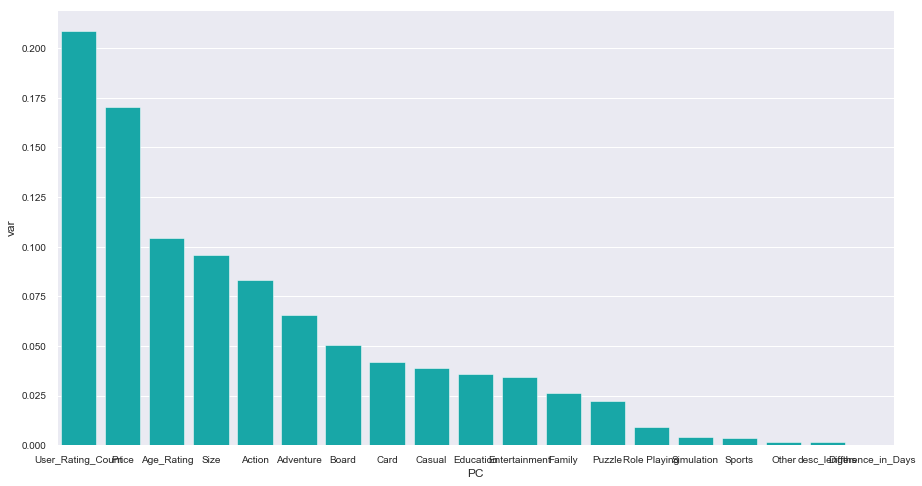

In [61]:
pca_df = pd.DataFrame({'var': pca.explained_variance_ratio_, 'PC': ['User_Rating_Count', 'Price', 'Age_Rating', 'Size', 'Action',
       'Adventure', 'Board', 'Card', 'Casual', 'Education', 'Entertainment',
       'Family', 'Puzzle', 'Role Playing', 'Simulation', 'Sports', 'Other',
       'desc_lengths', 'Difference_in_Days']})
plt.figure(figsize=(15,8))
sns.barplot(x='PC', y='var', data=pca_df, color='c');

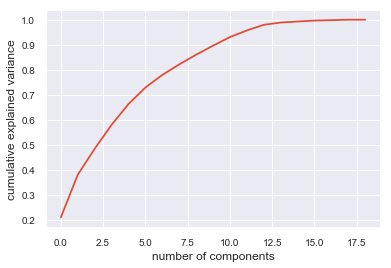

In [62]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [63]:
pca = PCA(n_components=10)
pca_X_train_transformed2 = pca.fit_transform(pca_X_train_transformed2)
pca_X_test_transformed2 = pca.transform(pca_X_test_transformed2)

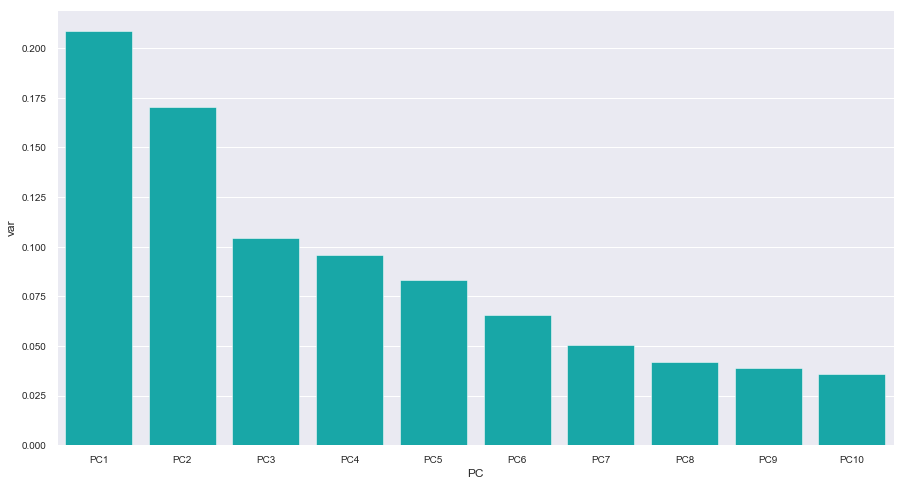

In [64]:
pca_df = pd.DataFrame({'var': pca.explained_variance_ratio_, 'PC': ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10']})
plt.figure(figsize=(15,8))
sns.barplot(x='PC', y='var', data=pca_df, color='c');

<a id="5.7"></a>

### 5.7 Decision Tree

In [65]:
X2 = df[['User_Rating_Count', 'desc_lengths', 'Difference_in_Days']]
y2 = df['Average_User_Rating']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=123)

In [66]:
mm_scaler = MinMaxScaler().fit(X_train2)
X_trans2 = mm_scaler.transform(X_train2)
X_train_transformed2 = pd.DataFrame(X_trans2, columns=X_train2.columns, index=X_train2.index)

mm_scaler = MinMaxScaler().fit(X_test2)
X_testy2 = mm_scaler.transform(X_test2)
X_test_transformed2 = pd.DataFrame(X_testy2, columns=X_test2.columns, index=X_test2.index)

In [67]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=123, class_weight='balanced')
dec_tree = clf_tree.fit(X_train_transformed2, y_train2)

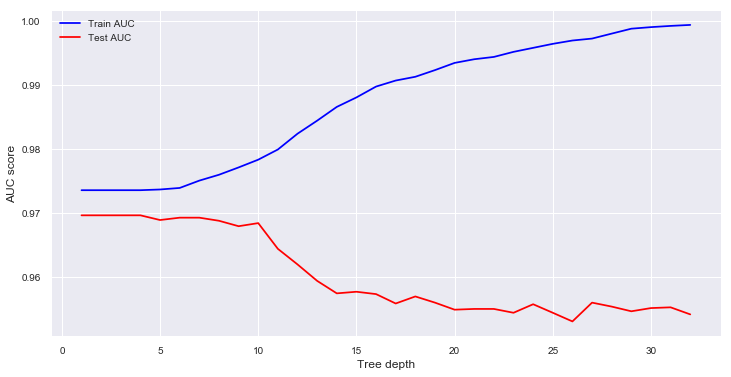

In [68]:
y_pred = clf_tree.predict(X_test_transformed2)
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
   dt.fit(X_train_transformed2, y_train2)
   train_pred = dt.predict(X_train_transformed2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_transformed2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [69]:
prediction_function(dec_tree,X_train_transformed2,X_test_transformed2,y_train2,y_test2,estimate='dec_tree')

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

 Score Report : 
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1993
         1.0       0.92      1.00      0.96      1365

    accuracy                           0.96      3358
   macro avg       0.96      0.97      0.96      3358
weighted avg       0.97      0.96      0.96      3358

Accuracy Score :  0.9624776652769506
Training Root Mean Square Error 0.1710702296038039
Testing Root Mean Square Error 0.19370682673320896
AUC :  0.9676968290114302 



<a id="5.8"></a>

### 5.8 Random Forest

In [70]:
baseline_forest = RandomForestClassifier()
mean_baseline_forest = np.mean(cross_val_score(baseline_forest, X_train_transformed2, y_train2, cv=3))

print(f"Mean Cross Val Score for Random Forest: {mean_baseline_forest :.2%}")

Mean Cross Val Score for Random Forest: 96.03%


In [71]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [72]:
rf_grid_search = GridSearchCV(baseline_forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_transformed2, y_train2)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 96.91%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 10}


In [73]:
forest = RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=10)
forest.fit(X_train_transformed2, y_train2)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
forest.score(X_train_transformed2, y_train2)

0.9690222652468539

In [75]:
forest.score(X_test_transformed2, y_test2)

0.9639666468135795

<a id="5.9"></a>

### 5.9 XGBoost 

In [76]:
xgb_clf_baseline = xgb.XGBClassifier()
xgb_clf_baseline.fit(X_train_transformed2, y_train2)
training_preds = xgb_clf_baseline.predict(X_train_transformed2)
val_preds = xgb_clf_baseline.predict(X_test_transformed2)
training_accuracy = accuracy_score(y_train2, training_preds)
val_accuracy = accuracy_score(y_test2, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 96.9%
Validation accuracy: 96.4%


In [77]:
param_grid = {
    "learning_rate": [1.0, 0.5, 0.1, 0.01],
    'max_depth': [1, 2, 4, 6, 10],
    'min_child_weight': [10],
    'subsample': [0.7, 0.8],
    'n_estimators': [3, 5, 30, 100, 250],
}

In [78]:
grid_clf = GridSearchCV(xgb_clf_baseline, param_grid, scoring='accuracy', cv=3, n_jobs=4)
grid_clf.fit(X_train_transformed2, y_train2)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 1.0
max_depth: 1
min_child_weight: 10
n_estimators: 30
subsample: 0.7


In [79]:
xgb_clf = xgb.XGBClassifier(learning_rate=1.0, max_depth=2, min_child_weight=10, n_estimators=5, subsample=0.7)
xgb_clf.fit(X_train_transformed2, y_train2)
training_preds = xgb_clf.predict(X_train_transformed2)
val_preds = xgb_clf.predict(X_test_transformed2)
training_accuracy = accuracy_score(y_train2, training_preds)
val_accuracy = accuracy_score(y_test2, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 96.9%
Validation accuracy: 96.4%


<a id="5.10"></a>

### 5.10 AdaBoost Classifier

In [80]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=123)
adaboost_clf.fit(X_train_transformed2, y_train2)
adaboost_train_preds = adaboost_clf.predict(X_train_transformed2)
adaboost_test_preds = adaboost_clf.predict(X_test_transformed2)

In [81]:
adaboost_confusion_matrix = confusion_matrix(y_test2, adaboost_test_preds)
adaboost_confusion_matrix

array([[1872,  121],
       [   1, 1364]])

In [82]:
print("AdaBoost Training Metrics")
display_acc_and_f1_score(y_train2, adaboost_train_preds, model_name='AdaBoost')
print("")
print("AdaBoost Testing Metrics")
display_acc_and_f1_score(y_test2, adaboost_test_preds, model_name='AdaBoost')
print("")

AdaBoost Training Metrics
Model: AdaBoost
Accuracy: 0.9690967309553951
F1-Score: 0.9640100598386958

AdaBoost Testing Metrics
Model: AdaBoost
Accuracy: 0.9636688505062537
F1-Score: 0.9571929824561403



In [83]:
adaboost_classification_report = classification_report(y_test2, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1993
         1.0       0.92      1.00      0.96      1365

    accuracy                           0.96      3358
   macro avg       0.96      0.97      0.96      3358
weighted avg       0.97      0.96      0.96      3358



In [84]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, X2, y2, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
0.9678349117336005


In [85]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [86]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X_train_transformed2, y_train2)

print(f"Training Accuracy: {adaboost_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {adaboost_grid_search.best_params_}")

Training Accuracy: 96.90%

Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


In [87]:
adb_score = adaboost_grid_search.score(X_test_transformed2, y_test2)
print('Adaboost grid search: ', adb_score)

Adaboost grid search:  0.9639666468135795


<a id="5.11"></a>

### 5.11 Gradient Boosting Classifier

In [88]:
# Instantiate a GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=123)
gbt_clf.fit(X_train_transformed2, y_train2)
gbt_clf_train_preds = gbt_clf.predict(X_train_transformed2)
gbt_clf_test_preds = gbt_clf.predict(X_test_transformed2)

In [89]:
gbt_confusion_matrix = confusion_matrix(y_test2, gbt_clf_test_preds)
gbt_confusion_matrix

array([[1872,  121],
       [   5, 1360]])

In [90]:
print("GBT Training Metrics")
display_acc_and_f1_score(y_train2, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("GBT Testing Metrics")
display_acc_and_f1_score(y_test2, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

GBT Training Metrics
Model: Gradient Boosted Trees
Accuracy: 0.9699903194578896
F1-Score: 0.9650386050143142

GBT Testing Metrics
Model: Gradient Boosted Trees
Accuracy: 0.9624776652769506
F1-Score: 0.95572733661279


In [91]:
gbt_classification_report = classification_report(y_test2, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1993
         1.0       0.92      1.00      0.96      1365

    accuracy                           0.96      3358
   macro avg       0.96      0.97      0.96      3358
weighted avg       0.97      0.96      0.96      3358



In [92]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X2, y2, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.9677157577270469


<a id="5.12"></a>

### 5.12 K-Nearest Neighbors

In [93]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed2, y_train2)
knn_clf_train_preds = knn_clf.predict(X_train_transformed2)
knn_clf_test_preds = knn_clf.predict(X_test_transformed2)

In [94]:
knn_confusion_matrix = confusion_matrix(y_test2, knn_clf_test_preds)
knn_confusion_matrix

array([[1558,  435],
       [ 519,  846]])

In [95]:
print("KNN Training Metrics")
display_acc_and_f1_score(y_train2, knn_clf_train_preds, model_name='K-Nearest Neighbors')
print("")
print("KNN Testing Metrics")
display_acc_and_f1_score(y_test2, knn_clf_test_preds, model_name='K-Nearest Neighbors')

KNN Training Metrics
Model: K-Nearest Neighbors
Accuracy: 0.7952193015116539
F1-Score: 0.7423646243207793

KNN Testing Metrics
Model: K-Nearest Neighbors
Accuracy: 0.7159023228111971
F1-Score: 0.6394557823129252


In [96]:
knn_classification_report = classification_report(y_test2, knn_clf_test_preds)
print(knn_classification_report)

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      1993
         1.0       0.66      0.62      0.64      1365

    accuracy                           0.72      3358
   macro avg       0.71      0.70      0.70      3358
weighted avg       0.71      0.72      0.71      3358



In [97]:
print('Mean KNN Cross-Val Score (k=5):')
print(cross_val_score(knn_clf, X2, y2, cv=5).mean())

Mean KNN Cross-Val Score (k=5):
0.8262387377197833


<a id="5.13"></a>

### 5.13 Ensemble / Meta-Classifier

In [98]:
eclf = VotingClassifier(estimators=[('KNN', knn_clf), ('GBT', gbt_clf), ('XGB', xgb_clf), ('RF', forest)], voting='soft')
eclf.fit(X_train_transformed2, y_train2)
eclf_train_preds = eclf.predict(X_train_transformed2)
eclf_test_preds = eclf.predict(X_test_transformed2)

In [99]:
print("ECLF Training Metrics")
display_acc_and_f1_score(y_train2, eclf_train_preds, model_name='ECLF')
print("")
print("ECLF Testing Metrics")
display_acc_and_f1_score(y_test2, eclf_test_preds, model_name='ECLF')
print("")

ECLF Training Metrics
Model: ECLF
Accuracy: 0.9691711966639363
F1-Score: 0.9641185647425897

ECLF Testing Metrics
Model: ECLF
Accuracy: 0.9639666468135795
F1-Score: 0.957558751315328



In [100]:
eclf_classification_report = classification_report(y_test2, eclf_test_preds)
print(eclf_classification_report)

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1993
         1.0       0.92      1.00      0.96      1365

    accuracy                           0.96      3358
   macro avg       0.96      0.97      0.96      3358
weighted avg       0.97      0.96      0.96      3358



<a id="006"></a>

## 6) Interpreting Data
***

<br>6.1 [Model Comparison - Intermediate](#6.1)
<br>6.2 [Model Comparison - Advanced](#6.2)
<br>6.3 [Conclusions](#6.3)


<a id="6.1"></a>

### 6.1 Model Comparison - Intermediate


In [101]:
model1 = model_score(baseline_log, X_train, X_test, y_train, y_test,"Baseline")
model2 = model_score(smote_logit, X_smote_train, X_smote_test, y_smote_train, y_smote_test,"SMOTE")
model3 = model_score(rfe,X_rfe_train,X_rfe_test,y_train,y_test,"RFE")
model4 = model_score(logit_lasso,X_train_transformed,X_test_transformed,y_train,y_test,"Lasso")
model5 = model_score(ridge_logit,X_train_transformed,X_test_transformed,y_train,y_test, "Ridge")

model_performances = pd.concat([model1,model2,model3,model4,model5],axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1)

dataframe  = ff.create_table(np.round(model_performances,4))

py.iplot(dataframe)

/Users/dmauger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



In [102]:
model_performances

layout = go.Layout(dict(title = "Model Comparison",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780))

trace1  = model_compare("Accuracy_score","#1bde65")
trace2  = model_compare('Recall_score',"#d93311")
trace3  = model_compare('Precision',"#3ae8d7")
trace4  = model_compare('f1_score',"#0f3175")

data = [trace1,trace2,trace3,trace4]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

<a id="6.2"></a>

### 6.2 Model Comparison - Advanced

In [103]:
def ML_model_score(model,train_x,test_x,train_y,test_y,name):
    model.fit(train_x,train_y)
    predictions  = model.predict(test_x)
    accuracy     = accuracy_score(test_y,predictions)
    recallscore  = recall_score(test_y,predictions)
    precision    = precision_score(test_y,predictions)
    roc_auc      = roc_auc_score(test_y,predictions)
    f1score      = f1_score(test_y,predictions) 
    cross_val    = cross_val_score(model,X2, y2, cv=5).mean()
    df_ML = pd.DataFrame({"Model"           : [name],
                       "Cross_Val"       : [cross_val],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc]})
    return df_ML

In [104]:
ML_model1 = ML_model_score(dec_tree, X_train_transformed2, X_test_transformed2, y_train2, y_test2,"Decision Tree")
ML_model2 = ML_model_score(forest, X_train_transformed2, X_test_transformed2, y_train2, y_test2,"Random Forest")
ML_model3 = ML_model_score(xgb_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2,"XGBoost")
ML_model4 = ML_model_score(adaboost_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2,"AdaBoost")
ML_model5 = ML_model_score(gbt_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2, "GBT")
ML_model6 = ML_model_score(knn_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2, "KNN")

ML_model_performances = pd.concat([ML_model1,ML_model2,ML_model3,ML_model4,ML_model5,ML_model6],axis = 0).reset_index()
ML_model_performances = ML_model_performances.drop(columns = "index",axis =1)

ML_dataframe  = ff.create_table(np.round(ML_model_performances,4))

py.iplot(ML_dataframe)

In [105]:
def ML_model_compare(metric,color) :
    ML_chart = go.Bar(y = ML_model_performances["Model"] ,
                    x = ML_model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color))
    return ML_chart

In [106]:
ML_model_performances

layout = go.Layout(dict(title = "ML Model Comparison",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780))

trace1  = ML_model_compare("Accuracy_score","#1bde65")
trace2  = ML_model_compare('Recall_score',"#d93311")
trace3  = ML_model_compare('Precision',"#3ae8d7")
trace4  = ML_model_compare('f1_score',"#0f3175")
trace5  = ML_model_compare('Cross_Val', "#ddf50a")
data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

<a id="6.3"></a>

### 6.3 Conclusions

>  **Business Insights:**
<br> 1. iOS Apps that have at least 3928 ratings are more likely to achieve a 4+ star rating. (vs 276 U4)
<br> 2. iOS Apps that have average description lengths of 1,400 characters are most successful. (vs 876 U4)
<br> 3. iOS Apps that were released 684 days ago are more likely to achieve a 4+ star rating. (vs 287 U4)
<br> 4. App price and in-app purchases does not have an effect on the rating, although profits may be impacted.

>  **Modeling Insights:**
<br> 1. Baseline models only achieved 41% accuracy.
<br> 2. Intermediate models improved to 72% accuracy.
<br> 3. Advanced models achieved highest accuracy at 96.3%. 

>  **Future Work:**
<br> 1. Determine threshold for rating count most likely to result in 4+ stars.
<br> 2. Examine the effect of consistent version updates on App success.
<br> 3. Gather data related to revenue and cost to identify the most effective use of investment.  